In [677]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [678]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [679]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405546 entries, 0 to 2405545
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.7 MB


# reduce to 1 million events

In [680]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [681]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,14717,0.24,14.717
1,15103,0.24,15.103
2,14901,0.24,14.901
3,15363,0.23,15.363
4,15342,0.23,15.342
...,...,...,...
999995,24683,0.14,24.683
999996,23881,0.15,23.881
999997,24167,0.15,24.167
999998,24301,0.15,24.301


### conversion Interval -> kWh

In [682]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,14717,0.24,14.717,244.615071
1,15103,0.24,15.103,238.363239
2,14901,0.24,14.901,241.594524
3,15363,0.23,15.363,234.329233
4,15342,0.23,15.342,234.649980
...,...,...,...,...
999995,24683,0.14,24.683,145.849370
999996,23881,0.15,23.881,150.747456
999997,24167,0.15,24.167,148.963463
999998,24301,0.15,24.301,148.142052


### Cumul Total interval

In [683]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [684]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

27152392004000

### Calcul de la date de base = now - cumul_interval

In [685]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 9, 7, 16, 12, 31, 435152)

In [686]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [687]:
conso_data.iloc[0]


Interval     14717.000000
kWh              0.240000
sec             14.717000
Wh             244.615071
cumul(ms)    14717.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [688]:
base

datetime.datetime(2024, 9, 7, 16, 12, 31, 435152)

## créer les dates

In [689]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-09-07 16:12:46.152152
1        2024-09-07 16:13:01.255152
2        2024-09-07 16:13:16.156152
3        2024-09-07 16:13:31.519152
4        2024-09-07 16:13:46.861152
                    ...            
999995   2025-07-18 22:30:46.815152
999996   2025-07-18 22:31:10.696152
999997   2025-07-18 22:31:34.863152
999998   2025-07-18 22:31:59.164152
999999   2025-07-18 22:32:23.439152
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [690]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,14717,0.24,14.717,244.615071,14717,2024-09-07 16:12:46.152152,07/09/24
1,15103,0.24,15.103,238.363239,29820,2024-09-07 16:13:01.255152,07/09/24
2,14901,0.24,14.901,241.594524,44721,2024-09-07 16:13:16.156152,07/09/24
3,15363,0.23,15.363,234.329233,60084,2024-09-07 16:13:31.519152,07/09/24
4,15342,0.23,15.342,234.649980,75426,2024-09-07 16:13:46.861152,07/09/24
...,...,...,...,...,...,...,...
999995,24683,0.14,24.683,145.849370,27152295380,2025-07-18 22:30:46.815152,18/07/25
999996,23881,0.15,23.881,150.747456,27152319261,2025-07-18 22:31:10.696152,18/07/25
999997,24167,0.15,24.167,148.963463,27152343428,2025-07-18 22:31:34.863152,18/07/25
999998,24301,0.15,24.301,148.142052,27152367729,2025-07-18 22:31:59.164152,18/07/25


### save conso_data with dates

In [691]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [692]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('18/07/25', 18, 7, 2025, '22:32:41')

In [693]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [694]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2719 entries, 997281 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2719 non-null   int64         
 1   kWh        2719 non-null   float64       
 2   sec        2719 non-null   float64       
 3   Wh         2719 non-null   float64       
 4   cumul(ms)  2719 non-null   int64         
 5   dates      2719 non-null   datetime64[ns]
 6   days       2719 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 169.9+ KB


In [695]:
end = time.time()
print(end - start)

21.413001537322998


### grouped by days

In [696]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [697]:
data = list(df_grp['kWh'])
print(data)

[1.061, 3.155, 2.617, 1.8, 1.791, 1.796, 1.794, 2.411, 1.926, 1.788, 1.793, 1.788, 1.819, 1.82, 1.817, 1.815, 1.818, 1.817, 1.815, 1.818, 1.784, 1.788, 1.784, 1.785, 1.783, 1.798, 1.788, 1.79, 1.785, 1.793, 1.801, 1.798, 1.799, 1.801, 1.785, 1.787, 1.788, 1.788, 1.798, 1.791, 1.799, 1.804, 1.793, 1.802, 1.798, 2.639, 4.0, 3.68, 3.895, 3.092, 3.347, 4.142, 3.35, 3.517, 3.986, 3.323, 3.732, 3.572, 3.979, 3.203, 3.316, 3.389, 4.094, 3.288, 3.392, 3.815, 3.23, 3.542, 3.292, 3.915, 3.355, 3.417, 3.754, 4.409, 3.602, 3.856, 3.371, 4.226, 3.496, 3.448, 3.282, 3.861, 3.687, 4.116, 3.213, 3.728, 3.809, 3.154, 3.686, 3.648, 3.39, 3.882, 3.19, 4.062, 3.452, 3.698, 4.077, 3.405, 4.536, 3.266, 3.457, 3.116, 3.222, 3.426, 3.352, 3.423, 3.424, 4.598, 4.552, 3.226, 3.453, 3.637, 3.926, 3.549, 4.459, 4.178, 4.083, 3.783, 3.724, 3.562, 3.537, 4.388, 3.163, 3.381, 3.402, 3.448, 3.611, 3.377, 4.552, 3.262, 3.787, 3.249, 3.599, 3.546, 3.289, 3.99, 3.282, 4.671, 3.941, 3.312, 4.434, 3.509, 4.786, 3.81, 3.08

In [698]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [699]:
end = time.time()
print(end - start)

22.08057713508606


### plot function by day
#### show('dd/mm/yy')

In [700]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


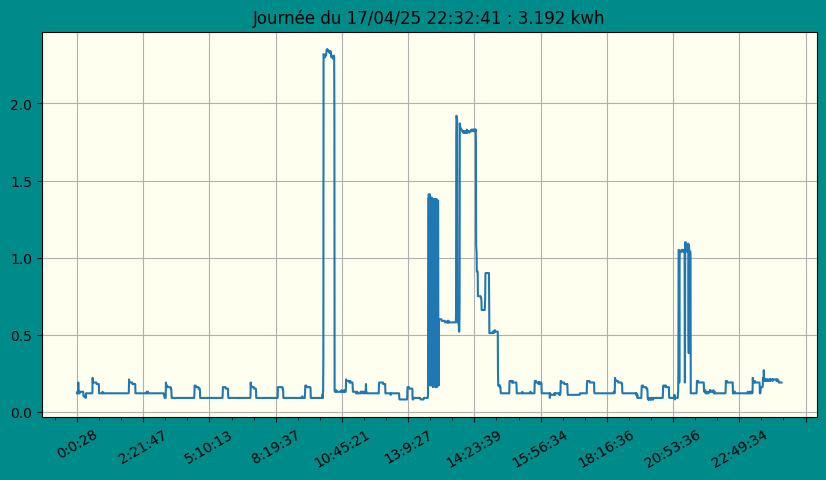

In [701]:
show('17/04/25')

In [702]:
end = time.time()
print(end - start)

23.594045639038086


### 1 kWh window in data of one day
#### df = conso_day

In [703]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997281,28463,0.13,28.463,126.479992,27071259283,2025-07-18 00:00:10.718152,18/07/25
997282,28455,0.13,28.455,126.515551,27071287738,2025-07-18 00:00:39.173152,18/07/25
997283,27560,0.13,27.560,130.624093,27071315298,2025-07-18 00:01:06.733152,18/07/25
997284,26806,0.13,26.806,134.298291,27071342104,2025-07-18 00:01:33.539152,18/07/25
997285,27321,0.13,27.321,131.766773,27071369425,2025-07-18 00:02:00.860152,18/07/25
...,...,...,...,...,...,...,...
999995,24683,0.14,24.683,145.849370,27152295380,2025-07-18 22:30:46.815152,18/07/25
999996,23881,0.15,23.881,150.747456,27152319261,2025-07-18 22:31:10.696152,18/07/25
999997,24167,0.15,24.167,148.963463,27152343428,2025-07-18 22:31:34.863152,18/07/25
999998,24301,0.15,24.301,148.142052,27152367729,2025-07-18 22:31:59.164152,18/07/25


In [704]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [705]:
df = conso_day
len(df)

2719

In [706]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-18 00:00:10.718152	2025-07-18 07:48:30.163152	7h 48m 19s 	1000
2025-07-18 07:48:30.163152	2025-07-18 15:21:22.636152	7h 32m 52s 	2000


In [707]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301237
dtype: float64

In [708]:
end = time.time()
print(end - start)

24.033515214920044


## mean for data grouped by days

In [709]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.174603
dtype: float64

In [710]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(2.719)

# conso by date


In [711]:
# select day
day = today

#day = '16/08/24'
day

'18/07/25'

In [712]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997281,28463,0.13,28.463,126.479992,27071259283,2025-07-18 00:00:10.718152,18/07/25
997282,28455,0.13,28.455,126.515551,27071287738,2025-07-18 00:00:39.173152,18/07/25
997283,27560,0.13,27.560,130.624093,27071315298,2025-07-18 00:01:06.733152,18/07/25
997284,26806,0.13,26.806,134.298291,27071342104,2025-07-18 00:01:33.539152,18/07/25
997285,27321,0.13,27.321,131.766773,27071369425,2025-07-18 00:02:00.860152,18/07/25
...,...,...,...,...,...,...,...
999995,24683,0.14,24.683,145.849370,27152295380,2025-07-18 22:30:46.815152,18/07/25
999996,23881,0.15,23.881,150.747456,27152319261,2025-07-18 22:31:10.696152,18/07/25
999997,24167,0.15,24.167,148.963463,27152343428,2025-07-18 22:31:34.863152,18/07/25
999998,24301,0.15,24.301,148.142052,27152367729,2025-07-18 22:31:59.164152,18/07/25


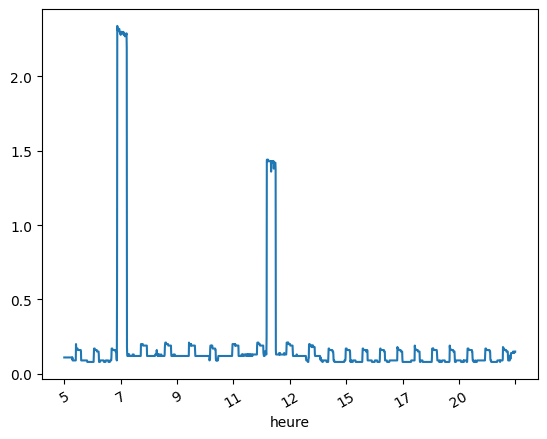

In [713]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [714]:
end = time.time()
print(end - start)

25.19944667816162


### grouped by 'heure'

In [715]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2719 entries, 997281 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2719 non-null   int64         
 1   kWh        2719 non-null   float64       
 2   sec        2719 non-null   float64       
 3   Wh         2719 non-null   float64       
 4   cumul(ms)  2719 non-null   int64         
 5   dates      2719 non-null   datetime64[ns]
 6   days       2719 non-null   object        
 7   heure      2719 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 191.2+ KB


In [716]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997281,28463,0.13,28.463,126.479992,27071259283,2025-07-18 00:00:10.718152,18/07/25
997282,28455,0.13,28.455,126.515551,27071287738,2025-07-18 00:00:39.173152,18/07/25
997283,27560,0.13,27.560,130.624093,27071315298,2025-07-18 00:01:06.733152,18/07/25
997284,26806,0.13,26.806,134.298291,27071342104,2025-07-18 00:01:33.539152,18/07/25
997285,27321,0.13,27.321,131.766773,27071369425,2025-07-18 00:02:00.860152,18/07/25
...,...,...,...,...,...,...,...
999995,24683,0.14,24.683,145.849370,27152295380,2025-07-18 22:30:46.815152,18/07/25
999996,23881,0.15,23.881,150.747456,27152319261,2025-07-18 22:31:10.696152,18/07/25
999997,24167,0.15,24.167,148.963463,27152343428,2025-07-18 22:31:34.863152,18/07/25
999998,24301,0.15,24.301,148.142052,27152367729,2025-07-18 22:31:59.164152,18/07/25


In [717]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [718]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     135
1     126
2     136
3     127
4     125
5     120
6     107
7     147
8     134
9     143
10    123
11    133
12    186
13    122
14     95
15    106
16     96
17     96
18     97
19    105
20     97
21     96
22     67
Name: kWh, dtype: int64

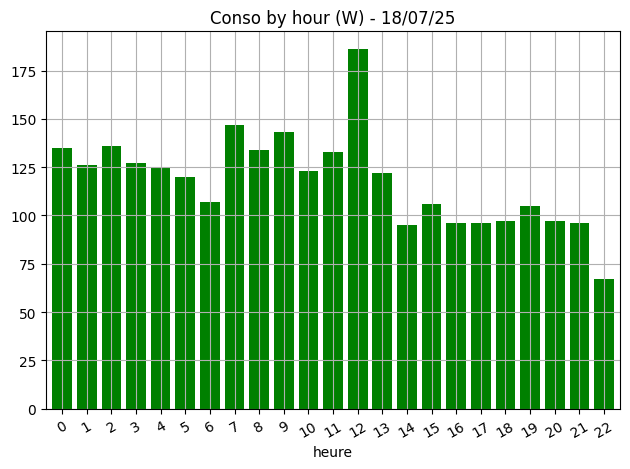

In [719]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [720]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 07/09/24 to 18/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     315 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [721]:
# give the periods of 1 kwh in a day
period()

2025-07-18 00:00:10.718152	2025-07-18 07:48:30.163152	7h 48m 19s 	1000


In [722]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [723]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [724]:
df_grp.mean()


kWh    3.174603
dtype: float64

In [725]:
df_grp.head()


,kWh
days,
07/09/24,1.061
08/09/24,3.155
09/09/24,2.617
10/09/24,1.800
11/09/24,1.791


In [726]:
df_grp.tail()


,kWh
days,
14/07/25,3.270
15/07/25,3.552
16/07/25,3.022
17/07/25,3.321
18/07/25,2.719


In [727]:
end = time.time()
print(end - start)

26.97572159767151


# plot les 100 derniers jours


In [728]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.00688
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

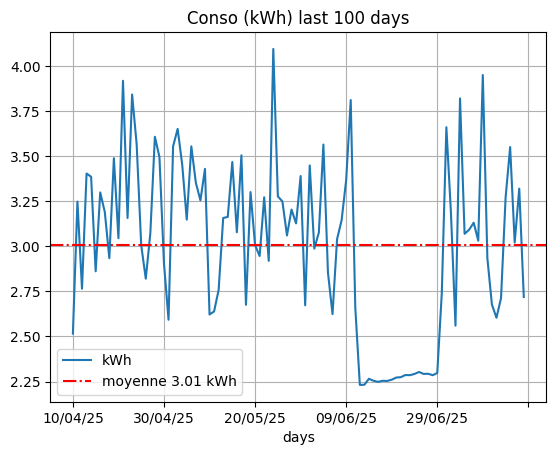

In [729]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [730]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.231
max,4.097


In [731]:
end = time.time()
print(end - start)

27.960675716400146


In [732]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('18/06/25', '13/07/25')

In [733]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.7914
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

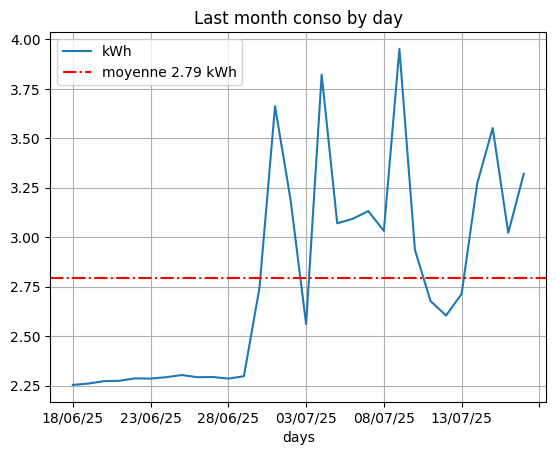

In [734]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [735]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/07/25 3.952
Min : 18/06/25 2.253


# Temps de conso par tranche de 1 kWh

In [736]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


3
2025-07-18 00:00:10.718152	2025-07-18 07:48:30.163152	7h 48m 19s 	1000
2025-07-18 07:48:30.163152	2025-07-18 15:21:22.636152	7h 32m 52s 	2000
2025-07-18 15:21:22.636152	2025-07-18 22:32:23.439152	7h 11m 0s 	719


In [737]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('22:32:41', 2.719, 2719)

In [738]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2719 entries, 997281 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2719 non-null   int64         
 1   kWh        2719 non-null   float64       
 2   sec        2719 non-null   float64       
 3   Wh         2719 non-null   float64       
 4   cumul(ms)  2719 non-null   int64         
 5   dates      2719 non-null   datetime64[ns]
 6   days       2719 non-null   object        
 7   heure      2719 non-null   object        
 8   hours      2719 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 212.4+ KB


In [739]:
conso_hours['heure'], conso_hours['hours']

(997281     0
 997282     0
 997283     0
 997284     0
 997285     0
           ..
 999995    22
 999996    22
 999997    22
 999998    22
 999999    22
 Name: heure, Length: 2719, dtype: object,
 997281    00
 997282    00
 997283    00
 997284    00
 997285    00
           ..
 999995    22
 999996    22
 999997    22
 999998    22
 999999    22
 Name: hours, Length: 2719, dtype: object)

In [740]:
end = time.time()
print(end - start)

30.435760021209717


# select number of days to display


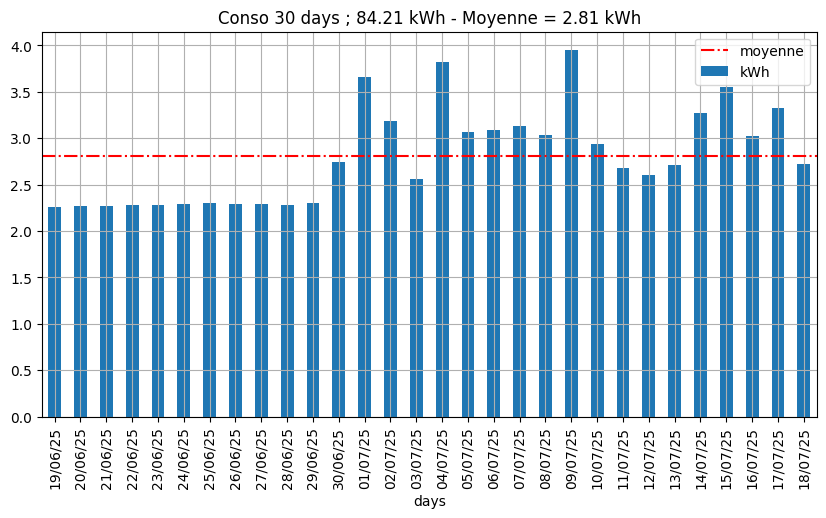

In [741]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


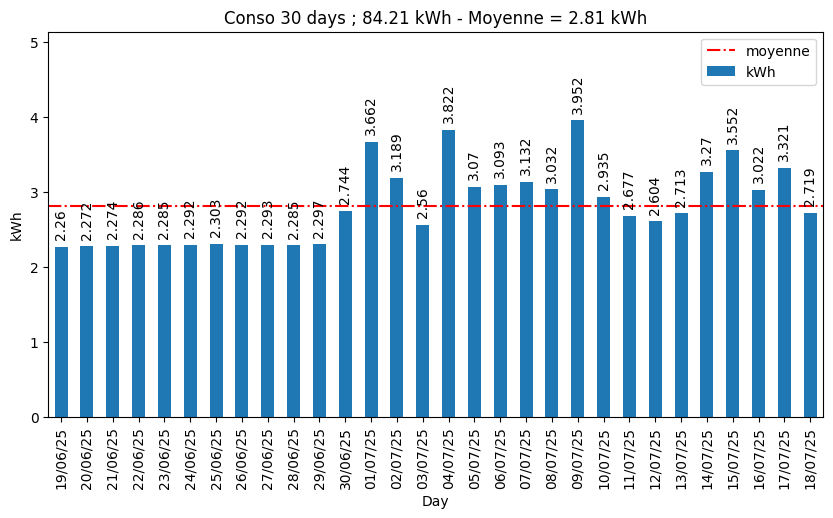

In [742]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [743]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
19/06/25    2.260
20/06/25    2.272
21/06/25    2.274
22/06/25    2.286
23/06/25    2.285
24/06/25    2.292
25/06/25    2.303
26/06/25    2.292
27/06/25    2.293
28/06/25    2.285
29/06/25    2.297
30/06/25    2.744
01/07/25    3.662
02/07/25    3.189
03/07/25    2.560
04/07/25    3.822
05/07/25    3.070
06/07/25    3.093
07/07/25    3.132
08/07/25    3.032
09/07/25    3.952
10/07/25    2.935
11/07/25    2.677
12/07/25    2.604
13/07/25    2.713
14/07/25    3.270
15/07/25    3.552
16/07/25    3.022
17/07/25    3.321
18/07/25    2.719
Name: kWh, dtype: float64

In [744]:
x_labels=df_grp.tail(span).index
x_labels

Index(['19/06/25', '20/06/25', '21/06/25', '22/06/25', '23/06/25', '24/06/25',
       '25/06/25', '26/06/25', '27/06/25', '28/06/25', '29/06/25', '30/06/25',
       '01/07/25', '02/07/25', '03/07/25', '04/07/25', '05/07/25', '06/07/25',
       '07/07/25', '08/07/25', '09/07/25', '10/07/25', '11/07/25', '12/07/25',
       '13/07/25', '14/07/25', '15/07/25', '16/07/25', '17/07/25', '18/07/25'],
      dtype='object', name='days')

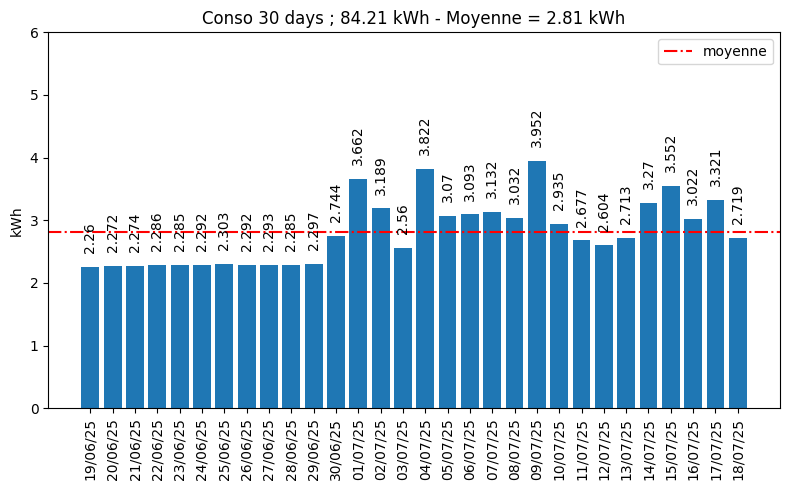

In [745]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [746]:
end = time.time()
print(end - start)

35.832924604415894


In [747]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

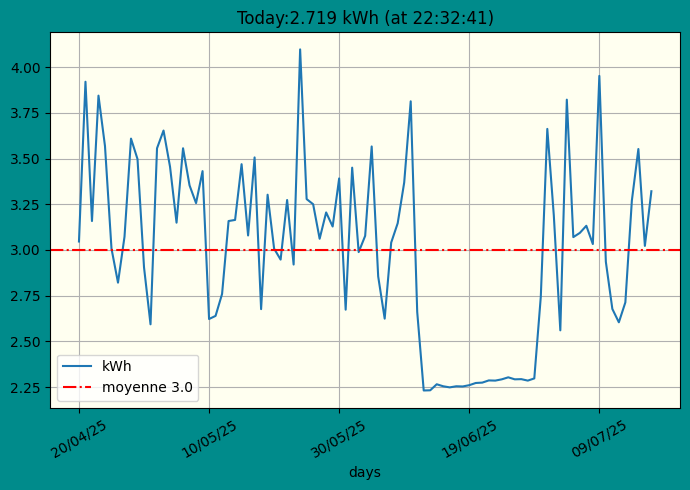

In [748]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

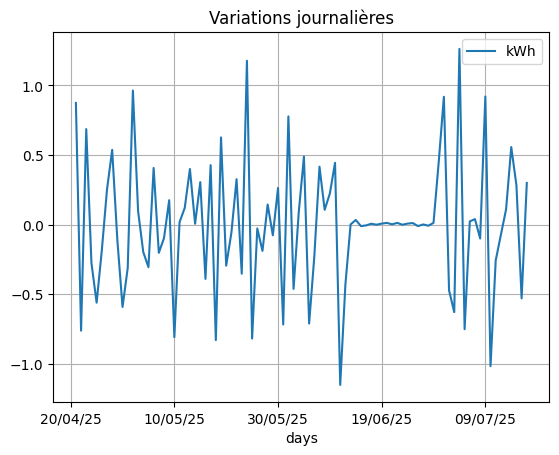

In [749]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [750]:
end = time.time()
print(end - start)

37.56334328651428


# Data from 21/08/23

In [751]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,14717,0.24,14.717,244.615071,14717,2024-09-07 16:12:46.152152,07/09/24,16,2024-09,07
1,15103,0.24,15.103,238.363239,29820,2024-09-07 16:13:01.255152,07/09/24,16,2024-09,07
2,14901,0.24,14.901,241.594524,44721,2024-09-07 16:13:16.156152,07/09/24,16,2024-09,07
3,15363,0.23,15.363,234.329233,60084,2024-09-07 16:13:31.519152,07/09/24,16,2024-09,07
4,15342,0.23,15.342,234.649980,75426,2024-09-07 16:13:46.861152,07/09/24,16,2024-09,07
...,...,...,...,...,...,...,...,...,...,...
999995,24683,0.14,24.683,145.849370,27152295380,2025-07-18 22:30:46.815152,18/07/25,22,2025-07,18
999996,23881,0.15,23.881,150.747456,27152319261,2025-07-18 22:31:10.696152,18/07/25,22,2025-07,18
999997,24167,0.15,24.167,148.963463,27152343428,2025-07-18 22:31:34.863152,18/07/25,22,2025-07,18
999998,24301,0.15,24.301,148.142052,27152367729,2025-07-18 22:31:59.164152,18/07/25,22,2025-07,18


In [752]:
end = time.time()
print(end - start)

82.51968955993652


In [753]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

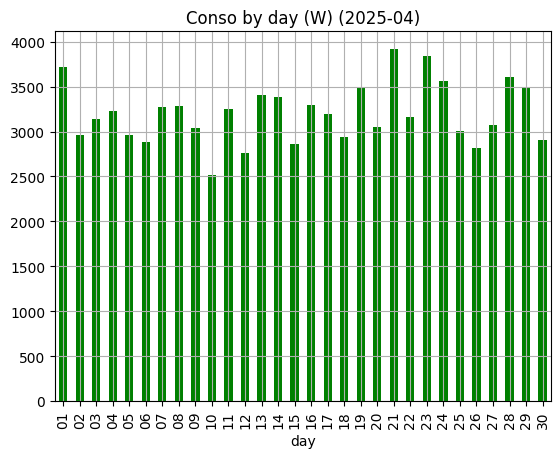

In [754]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [755]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3200.4333333333334)

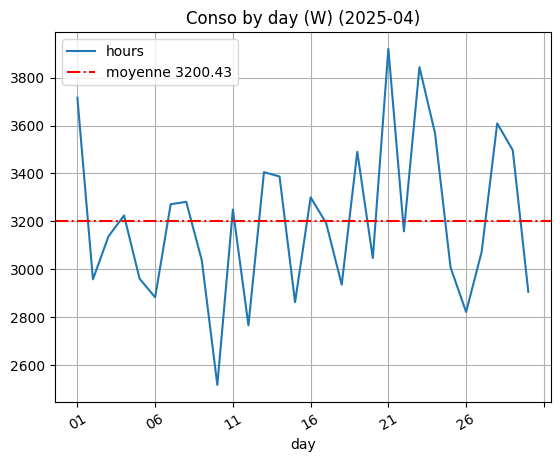

In [756]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [757]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

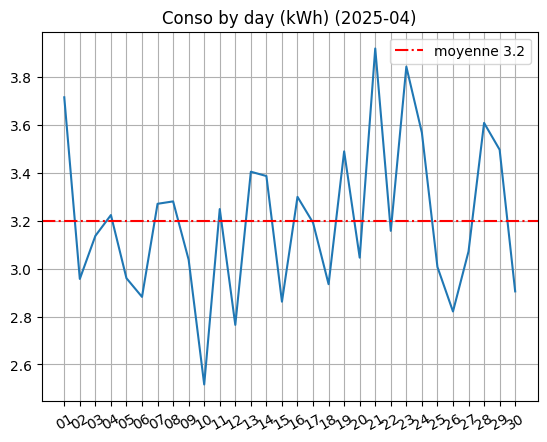

In [758]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [759]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [760]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [761]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-09,45400,45400,45400
2024-10,73317,73317,73317
2024-11,108175,108175,108175
2024-12,113981,113981,113981
2025-01,113881,113881,113881
2025-02,104274,104274,104274
2025-03,111819,111819,111819
2025-04,96013,96013,96013
2025-05,98606,98606,98606


In [762]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [763]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [764]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
07/09/24,1061
08/09/24,3155
09/09/24,2617
10/09/24,1800
11/09/24,1791
...,...
14/07/25,3270
15/07/25,3552
16/07/25,3022


In [765]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,14717,0.24,14.717,244.615071,14717,2024-09-07 16:12:46.152152,07/09/24,16,2024-09,07
1,15103,0.24,15.103,238.363239,29820,2024-09-07 16:13:01.255152,07/09/24,16,2024-09,07
2,14901,0.24,14.901,241.594524,44721,2024-09-07 16:13:16.156152,07/09/24,16,2024-09,07
3,15363,0.23,15.363,234.329233,60084,2024-09-07 16:13:31.519152,07/09/24,16,2024-09,07
4,15342,0.23,15.342,234.649980,75426,2024-09-07 16:13:46.861152,07/09/24,16,2024-09,07
...,...,...,...,...,...,...,...,...,...,...
999995,24683,0.14,24.683,145.849370,27152295380,2025-07-18 22:30:46.815152,18/07/25,22,2025-07,18
999996,23881,0.15,23.881,150.747456,27152319261,2025-07-18 22:31:10.696152,18/07/25,22,2025-07,18
999997,24167,0.15,24.167,148.963463,27152343428,2025-07-18 22:31:34.863152,18/07/25,22,2025-07,18
999998,24301,0.15,24.301,148.142052,27152367729,2025-07-18 22:31:59.164152,18/07/25,22,2025-07,18


In [766]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
07/09/24 16    0       07/09/24    16  0.24
               1       07/09/24    16  0.24
               2       07/09/24    16  0.24
               3       07/09/24    16  0.23
               4       07/09/24    16  0.23
...                         ...   ...   ...
18/07/25 22    999995  18/07/25    22  0.14
               999996  18/07/25    22  0.15
               999997  18/07/25    22  0.15
               999998  18/07/25    22  0.15
               999999  18/07/25    22  0.15

[1000000 rows x 3 columns]

In [767]:
groupallbyday.indices.keys()

dict_keys(['07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/11/24', '21/11/24', '22/11/24', '23/11/24', '24/11/24', '25/11/24', '26/11/24', '27/11/24', '28/1

In [768]:
groupallbydayhours.indices.keys()

dict_keys([('07/09/24', '16'), ('07/09/24', '17'), ('07/09/24', '18'), ('07/09/24', '19'), ('07/09/24', '20'), ('07/09/24', '21'), ('07/09/24', '22'), ('07/09/24', '23'), ('08/09/24', '16'), ('08/09/24', '17'), ('08/09/24', '18'), ('08/09/24', '19'), ('08/09/24', '20'), ('08/09/24', '21'), ('08/09/24', '22'), ('08/09/24', '23'), ('08/09/24', '00'), ('08/09/24', '01'), ('08/09/24', '02'), ('08/09/24', '03'), ('08/09/24', '04'), ('08/09/24', '05'), ('08/09/24', '06'), ('08/09/24', '07'), ('08/09/24', '08'), ('08/09/24', '09'), ('08/09/24', '10'), ('08/09/24', '11'), ('08/09/24', '12'), ('08/09/24', '13'), ('08/09/24', '14'), ('08/09/24', '15'), ('09/09/24', '16'), ('09/09/24', '17'), ('09/09/24', '18'), ('09/09/24', '19'), ('09/09/24', '20'), ('09/09/24', '21'), ('09/09/24', '22'), ('09/09/24', '23'), ('09/09/24', '00'), ('09/09/24', '01'), ('09/09/24', '02'), ('09/09/24', '03'), ('09/09/24', '04'), ('09/09/24', '05'), ('09/09/24', '06'), ('09/09/24', '07'), ('09/09/24', '08'), ('09/09/2

In [769]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
07/09/24,1061,1061
08/09/24,3155,3155
09/09/24,2617,2617
10/09/24,1800,1800
11/09/24,1791,1791
...,...,...
14/07/25,3270,3270
15/07/25,3552,3552
16/07/25,3022,3022


In [770]:
grp_by_day['kWh'].cumsum()

days
07/09/24       1061
08/09/24       4216
09/09/24       6833
10/09/24       8633
11/09/24      10424
             ...   
14/07/25     987386
15/07/25     990938
16/07/25     993960
17/07/25     997281
18/07/25    1000000
Name: kWh, Length: 315, dtype: int64

In [771]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
07/09/24 16     136
         17     178
         18     162
         19     117
         20     118
...             ...
18/07/25 18      97
         19     105
         20      97
         21      96
         22      67

[7543 rows x 1 columns]

In [772]:
grp_by_dayhours['kWh'].cumsum()

days      hours
07/09/24  16           136
          17           314
          18           476
          19           593
          20           711
                    ...   
18/07/25  18        999635
          19        999740
          20        999837
          21        999933
          22       1000000
Name: kWh, Length: 7543, dtype: int64

In [773]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
07/09/24 16     136     136   NaN
         17     178     314  42.0
         18     162     476 -16.0
         19     117     593 -45.0
         20     118     711   1.0
...             ...     ...   ...
18/07/25 18      97    2354   1.0
         19     105    2459   8.0
         20      97    2556  -8.0
         21      96    2652  -1.0
         22      67    2719 -29.0

[7543 rows x 3 columns]

In [774]:
today, grp_by_dayhours.loc[today]

('18/07/25',
        kWh  cumsum  diff
 hours                   
 00     135     135   NaN
 01     126     261  -9.0
 02     136     397  10.0
 03     127     524  -9.0
 04     125     649  -2.0
 05     120     769  -5.0
 06     107     876 -13.0
 07     147    1023  40.0
 08     134    1157 -13.0
 09     143    1300   9.0
 10     123    1423 -20.0
 11     133    1556  10.0
 12     186    1742  53.0
 13     122    1864 -64.0
 14      95    1959 -27.0
 15     106    2065  11.0
 16      96    2161 -10.0
 17      96    2257   0.0
 18      97    2354   1.0
 19     105    2459   8.0
 20      97    2556  -8.0
 21      96    2652  -1.0
 22      67    2719 -29.0)

Text(0.5, 1.0, 'Cumul journalier')

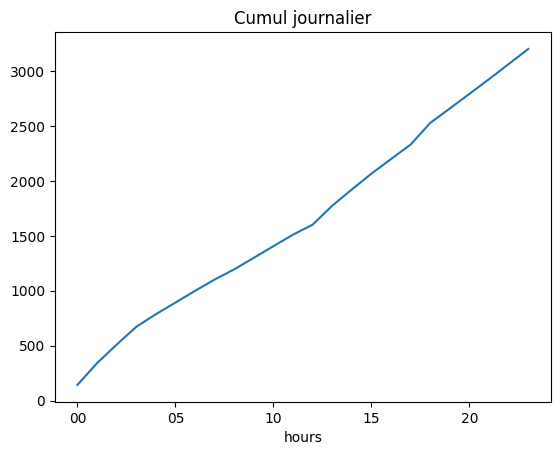

In [775]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

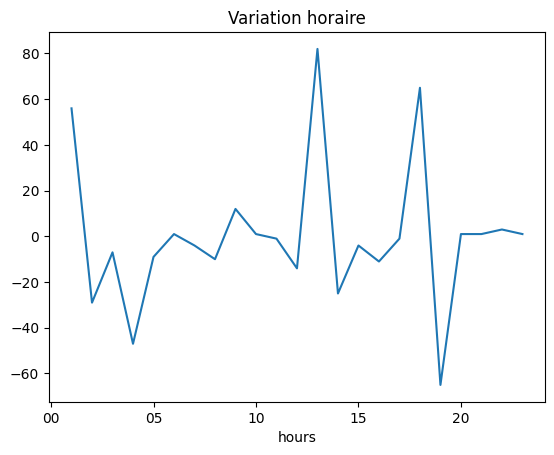

In [776]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [777]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

315

In [778]:
df_grp.tail(n)['kWh'].describe()


count    315.000000
mean       3.174603
std        0.738191
min        1.061000
25%        2.793000
50%        3.302000
75%        3.650500
max        4.786000
Name: kWh, dtype: float64

In [779]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [780]:
n, np.nanmean(df_grp.tail(n))

(315, np.float64(3.1746031746031744))

Text(0.5, 1.0, '315 days')

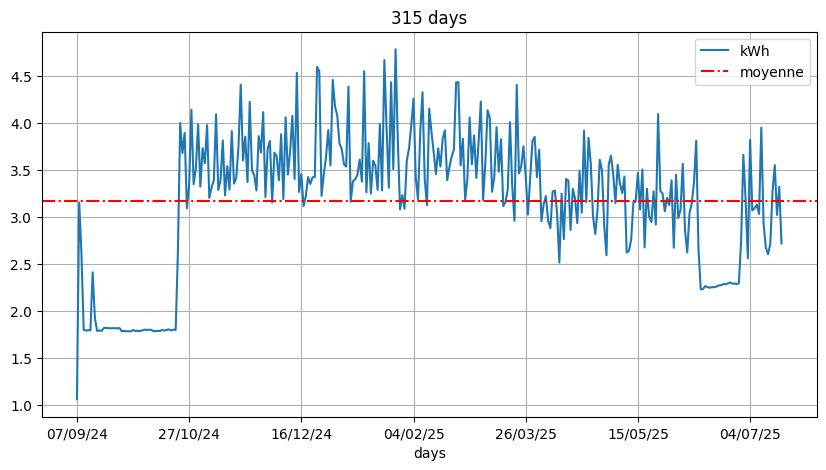

In [781]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

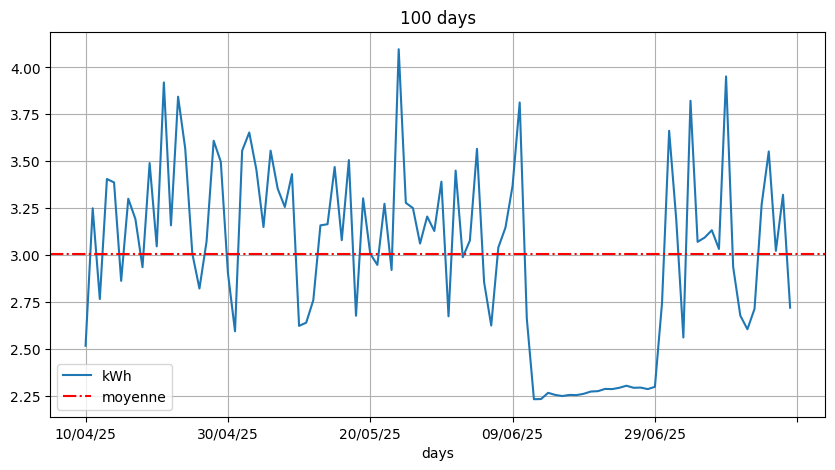

In [782]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [783]:
np.nanmean(df_grp.tail(span))

np.float64(3.0068800000000007)

In [784]:
df_grp['kWh']

days
07/09/24    1.061
08/09/24    3.155
09/09/24    2.617
10/09/24    1.800
11/09/24    1.791
            ...  
14/07/25    3.270
15/07/25    3.552
16/07/25    3.022
17/07/25    3.321
18/07/25    2.719
Name: kWh, Length: 315, dtype: float64

In [785]:
df_grp.describe()

,kWh
count,315.000000
mean,3.174603
std,0.738191
min,1.061000
25%,2.793000
50%,3.302000
75%,3.650500
max,4.786000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

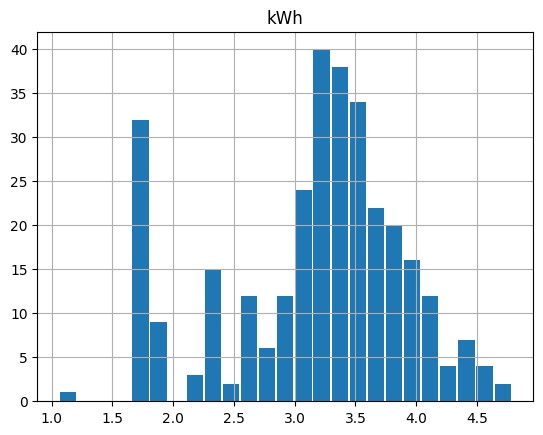

In [786]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [787]:
df_grp.tail(span)['kWh']

days
10/04/25    2.516
11/04/25    3.249
12/04/25    2.765
13/04/25    3.405
14/04/25    3.387
            ...  
14/07/25    3.270
15/07/25    3.552
16/07/25    3.022
17/07/25    3.321
18/07/25    2.719
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [788]:
day

'18/07/25'

In [789]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,135,135,NaN
01,126,261,-9.0
02,136,397,10.0
03,127,524,-9.0
04,125,649,-2.0
05,120,769,-5.0
06,107,876,-13.0
07,147,1023,40.0
08,134,1157,-13.0


In [790]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


23

In [791]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 24)

In [792]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [793]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [794]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
Name: days, dtype: float64

In [795]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [796]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 00 to 22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     23 non-null     int64  
 1   cumsum  23 non-null     int64  
 2   diff    22 non-null     float64
 3   days    23 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 920.0+ bytes


In [797]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
Name: days, dtype: float64

In [798]:
day

'18/07/25'

In [799]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,135,135,NaN,1.0
01,126,261,-9.0,2.0
02,136,397,10.0,3.0
03,127,524,-9.0,4.0
04,125,649,-2.0,5.0
05,120,769,-5.0,6.0
06,107,876,-13.0,7.0
07,147,1023,40.0,8.0
08,134,1157,-13.0,9.0


In [800]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_11012\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(2.7190000000000003)

In [801]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
07/09/24 16     136     136   NaN   NaN
         17     178     314  42.0   NaN
         18     162     476 -16.0   NaN
         19     117     593 -45.0   NaN
         20     118     711   1.0   NaN
...             ...     ...   ...   ...
18/07/25 18      97    2354   1.0  19.0
         19     105    2459   8.0  20.0
         20      97    2556  -8.0  21.0
         21      96    2652  -1.0  22.0
         22      67    2719 -29.0  23.0

[7543 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '18/07/25: kWh    2.719\ndtype: float64')

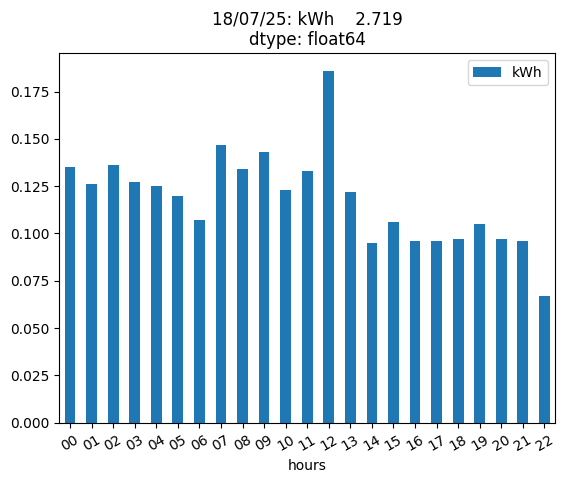

In [802]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [803]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'],
      dtype='object', name='hours')

# Conso du jour


In [804]:
grp_by_dayhours.count()

kWh       7543
cumsum    7543
diff      7228
days        23
dtype: int64

'27/01/25'

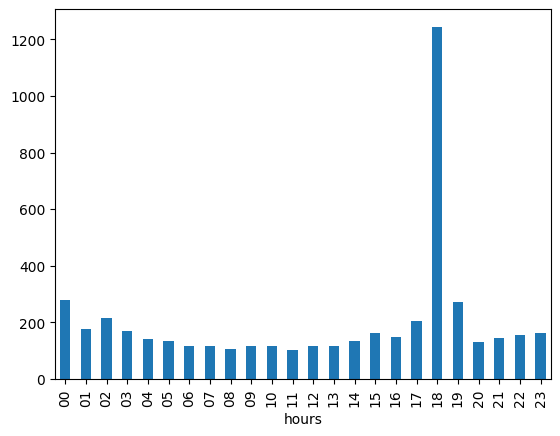

In [805]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [806]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 300.688 , Moyenne= 3.0068800000000007


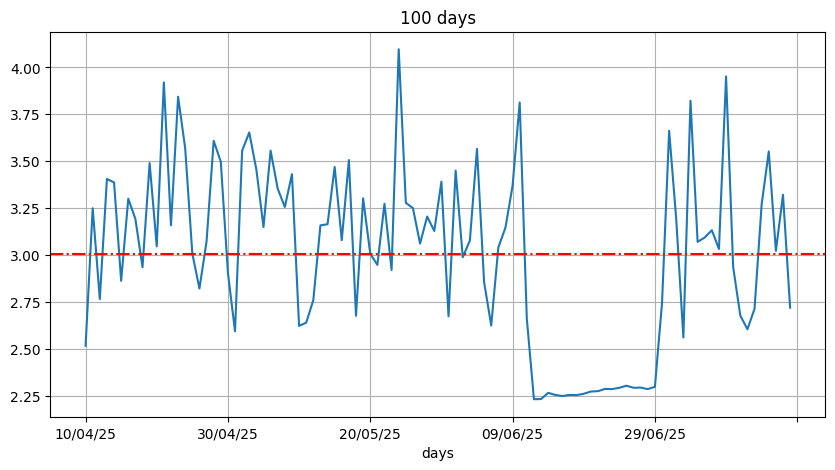

In [807]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [808]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 22:34:06, Minutes in day: 1354


In [809]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [810]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:45.56


In [811]:
end - start

105.55816078186035

In [812]:
#df = conso_day
show_tranches()

3
2025-07-18 00:00:10.718152	2025-07-18 07:48:30.163152	7h 48m 19s 	1000
2025-07-18 07:48:30.163152	2025-07-18 15:21:22.636152	7h 32m 52s 	2000
2025-07-18 15:21:22.636152	2025-07-18 22:32:23.439152	7h 11m 0s 	719


In [813]:
df_grp.tail(7)['kWh']

days
12/07/25    2.604
13/07/25    2.713
14/07/25    3.270
15/07/25    3.552
16/07/25    3.022
17/07/25    3.321
18/07/25    2.719
Name: kWh, dtype: float64

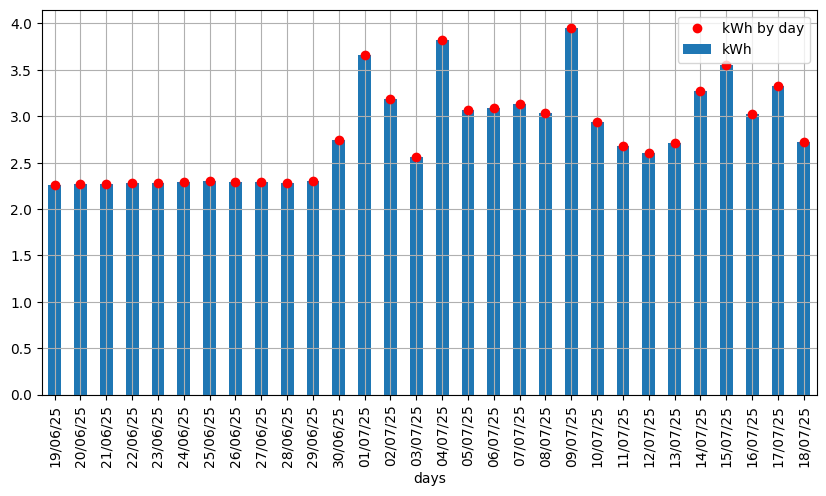

In [814]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), kind='bar', layout='tight', grid=True)
plt.plot(df_grp.tail(30)['kWh'], 'ro', label='kWh by day')
plt.legend()

# Today

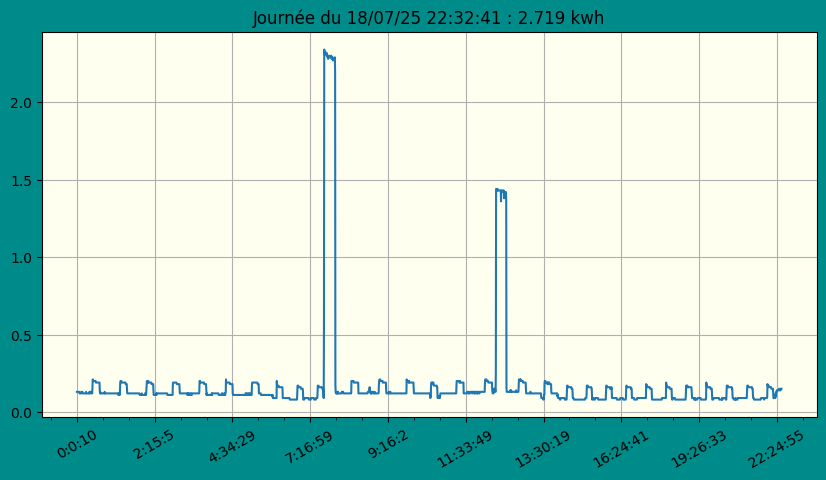

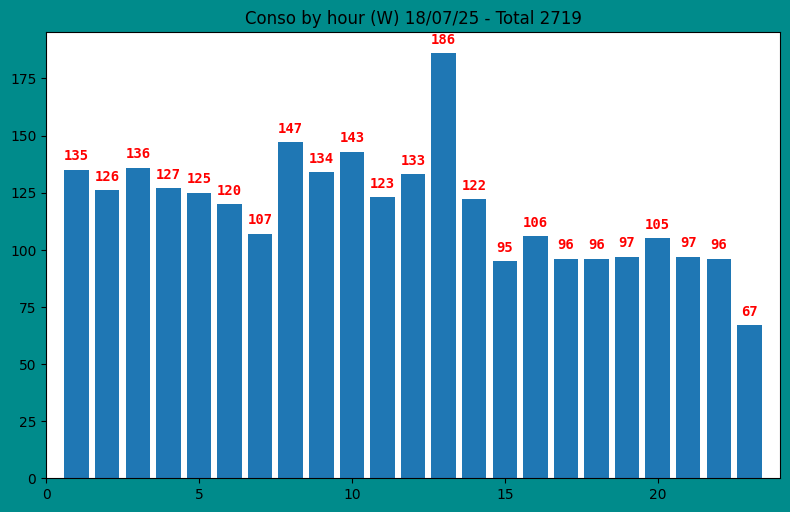

In [815]:
show(today,bgcolor='ivory')
conso_by_hour(today)

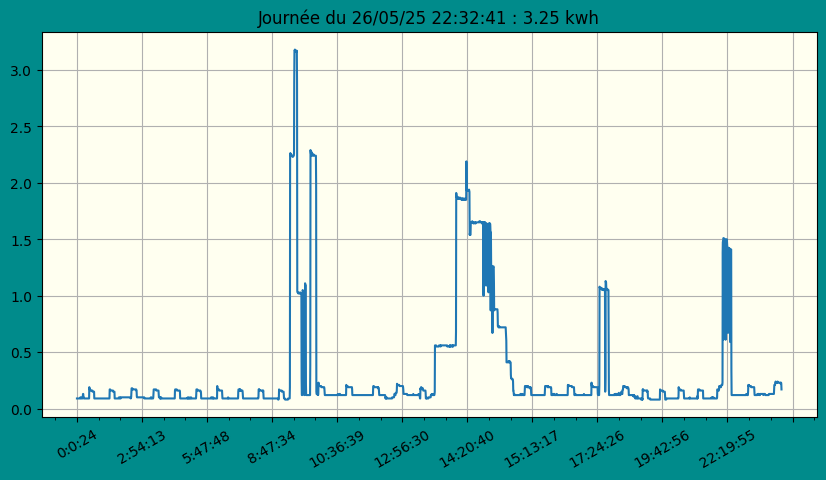

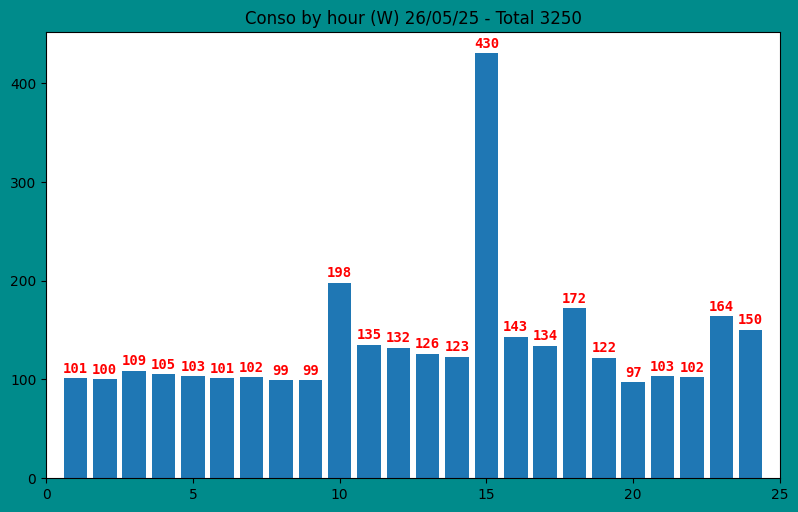

In [816]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4786)

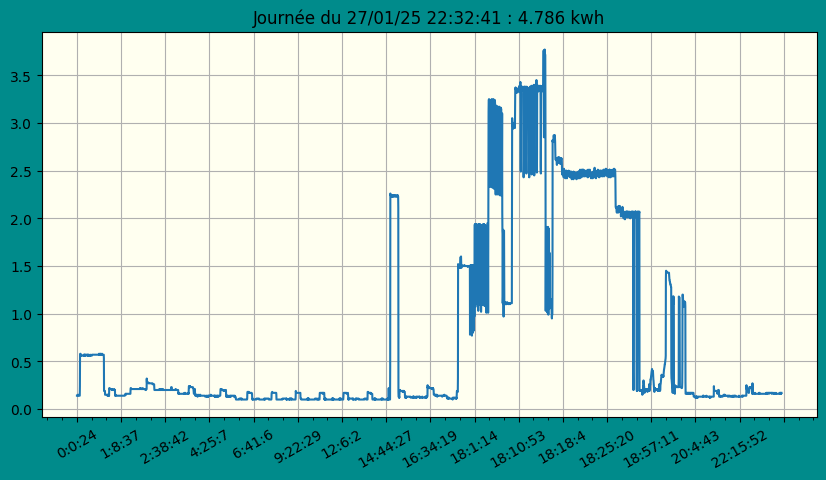

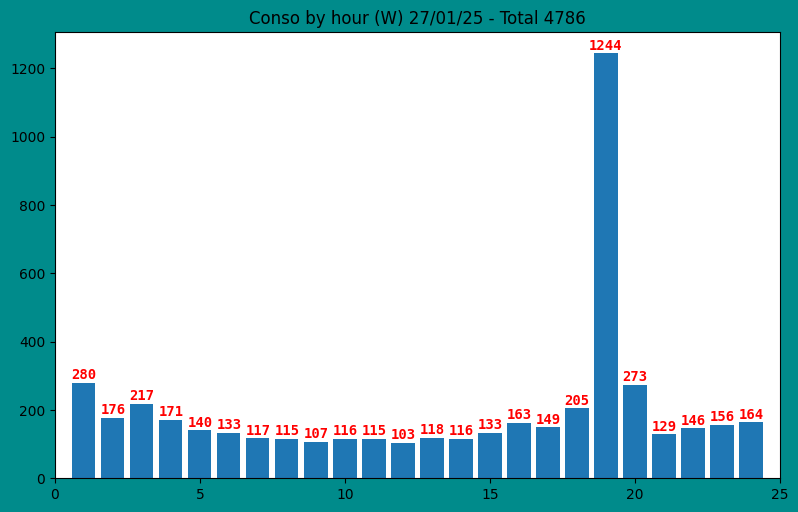

In [817]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

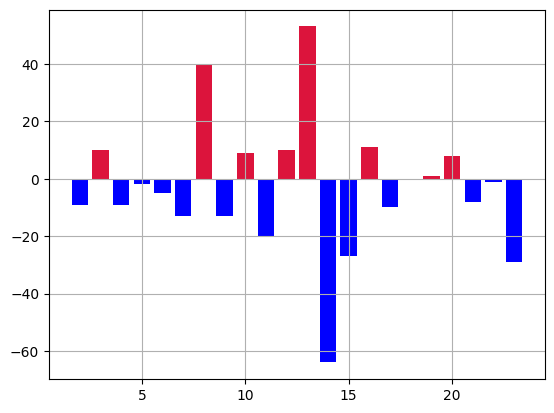

In [818]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

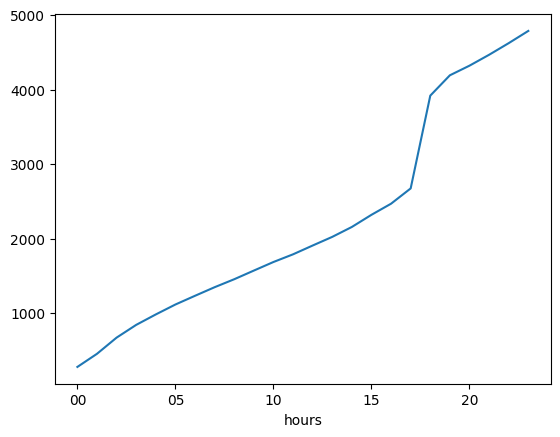

In [819]:
data.cumsum().plot()


<Axes: xlabel='hours'>

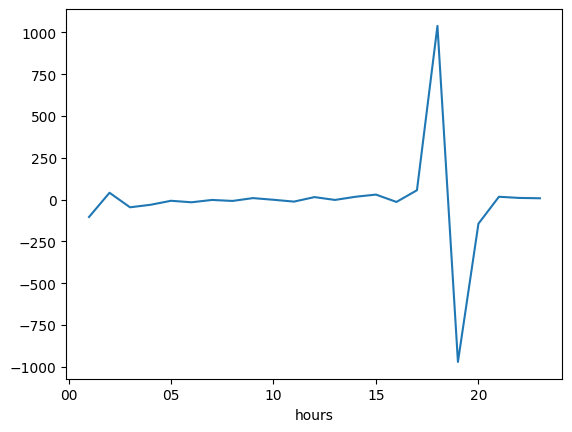

In [820]:
# evolution par heure
data.diff().plot()

In [821]:
data.diff().describe()

count      23.000000
mean       -5.043478
std       306.289299
min      -971.000000
25%       -15.000000
50%        -2.000000
75%        16.000000
max      1039.000000
Name: kWh, dtype: float64

<Axes: >

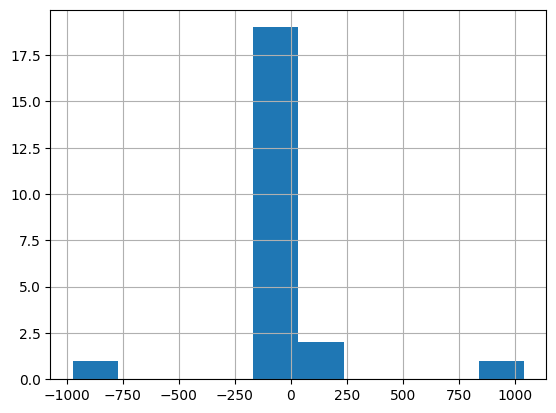

In [822]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [823]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'read_csv_conso.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_ch

# list store files csv


In [824]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('27/01/25', None)

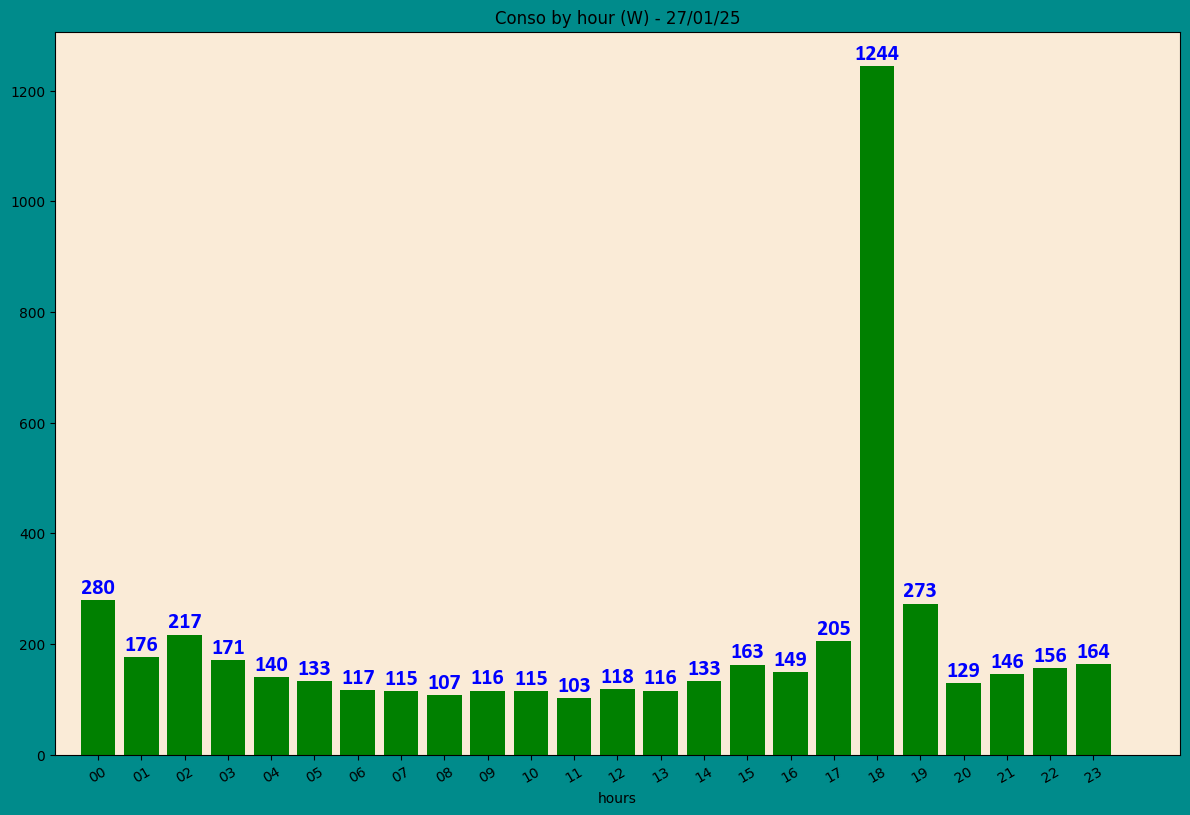

In [825]:
day,conso_byhour(day)

In [826]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


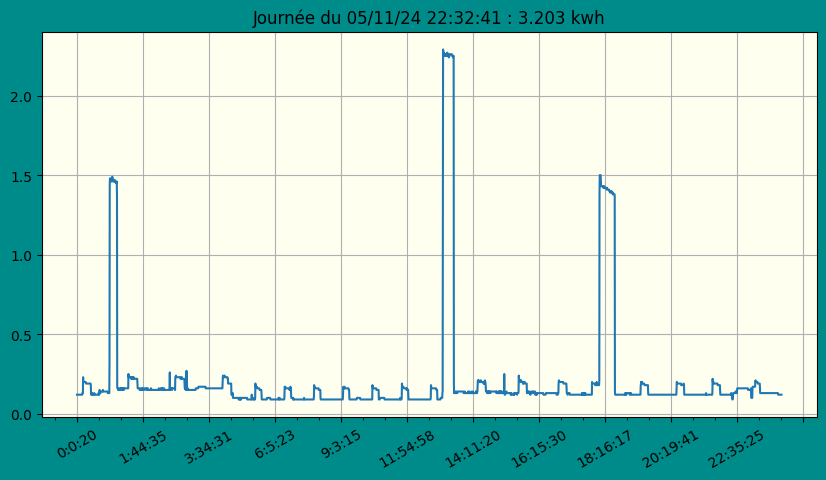

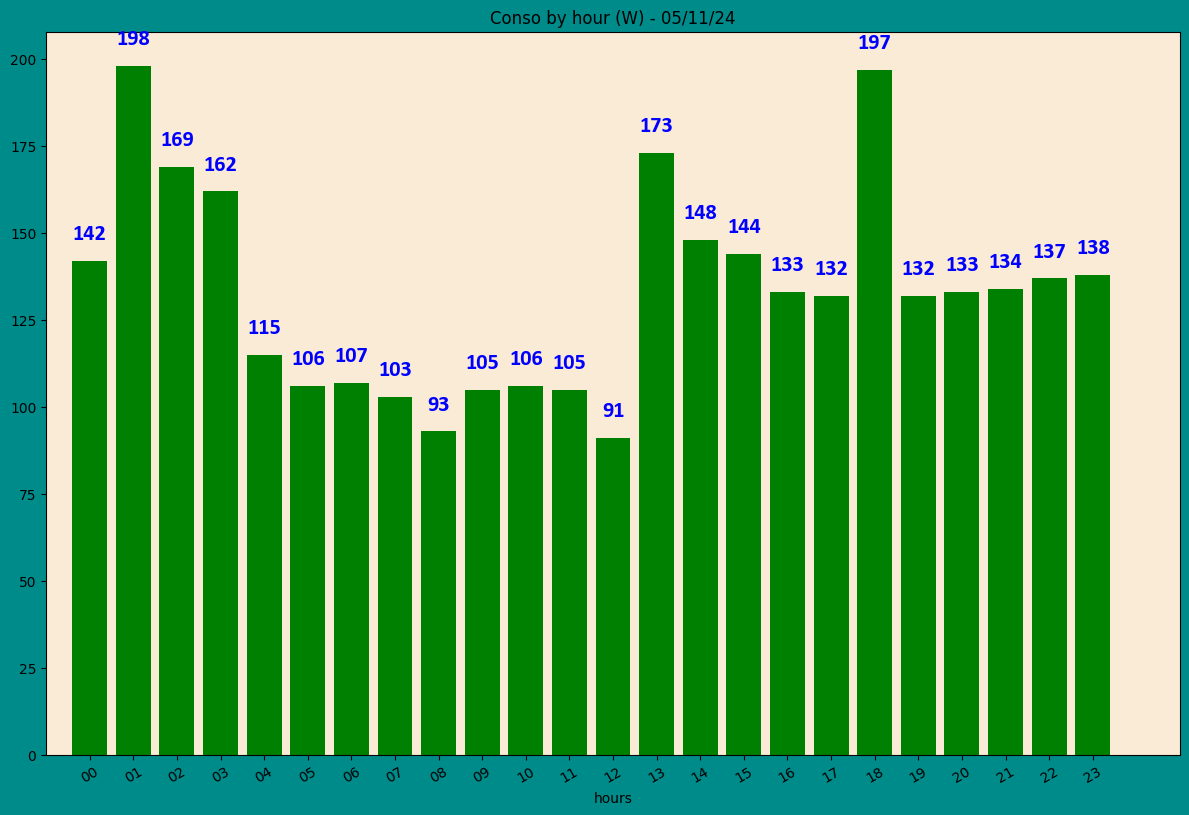

In [827]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [828]:
month

,day,hours,months,kWh
670847,01,00,2025-04,0.21
670848,01,00,2025-04,0.21
670849,01,00,2025-04,0.21
670850,01,00,2025-04,0.21
670851,01,00,2025-04,0.21
...,...,...,...,...
766855,30,23,2025-04,0.09
766856,30,23,2025-04,0.09
766857,30,23,2025-04,0.09
766858,30,23,2025-04,0.09


In [829]:
month.describe()


,kWh
count,96013.000000
mean,0.310189
std,0.547336
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

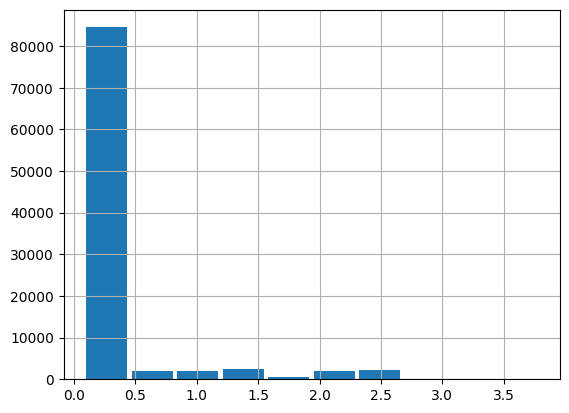

In [830]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

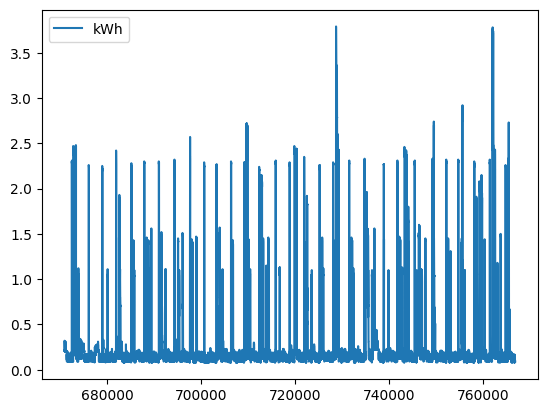

In [831]:
month.plot()

In [832]:
# index with max conso in this month
month.idxmax().kWh

np.int64(728720)

In [833]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       763955
hours     674397
months    670847
kWh       728720
dtype: int64

In [834]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [835]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
07/09/24 16     136     136   NaN   NaN
         17     178     314  42.0   NaN
         18     162     476 -16.0   NaN
         19     117     593 -45.0   NaN
         20     118     711   1.0   NaN
...             ...     ...   ...   ...
18/07/25 18      97    2354   1.0  19.0
         19     105    2459   8.0  20.0
         20      97    2556  -8.0  21.0
         21      96    2652  -1.0  22.0
         22      67    2719 -29.0  23.0

[7543 rows x 4 columns]

In [836]:
month

,day,hours,months,kWh
670847,01,00,2025-04,0.21
670848,01,00,2025-04,0.21
670849,01,00,2025-04,0.21
670850,01,00,2025-04,0.21
670851,01,00,2025-04,0.21
...,...,...,...,...
766855,30,23,2025-04,0.09
766856,30,23,2025-04,0.09
766857,30,23,2025-04,0.09
766858,30,23,2025-04,0.09


In [837]:
month.idxmax()


day       763955
hours     674397
months    670847
kWh       728720
dtype: int64

In [838]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 728720, dtype: object

In [839]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       179
          01       175
          02       172
          03       122
          04       114
          05       110
          06       109
          07       100
          08       111
          09       110
          10       108
          11        99
          12       168
          13       144
          14       147
          15       134
          16       202
          17       143
          18       152
          19       191
          20       150
          21       146
          22       142
          23       174
Name: kWh, dtype: int64

In [840]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'16'

<Axes: xlabel='days,hours'>

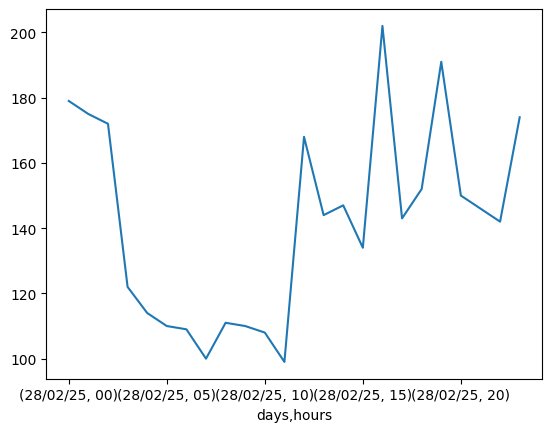

In [841]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [842]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [843]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [844]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [845]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB